# ResNet Model transfer learning

## Load dataset

### Train dataset

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = 224
# All images will be rescaled by 1./255 (for data normalization)
# I add new augmented samples using: rotations, zooming, width and height shifts, shearing, etc.
# This doesn't increase the number of original samples but provides varied data during training, helping with generalization.
train_datagen = ImageDataGenerator(
       rescale=1/255,
       rotation_range=10,
       width_shift_range=0.2,
       height_shift_range=0.2,
       shear_range=0.2,
       zoom_range=0.2,
       horizontal_flip=True,
       fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
       './data/train/', 
       target_size=(image_size, image_size),
       batch_size=16,
       class_mode='categorical')


Found 905 images belonging to 5 classes.


### Test dataset

In [2]:
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

test_generator =  test_datagen.flow_from_directory("./data/test/",
                                                        batch_size=16,
                                                        class_mode  = 'categorical',
                                                        target_size = (image_size, image_size))

Found 145 images belonging to 5 classes.


## Create the model

### Load pre-trained ResNet model

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers

# Load ResNet50 model, pre-trained on ImageNet
base_model = ResNet50(input_shape=(224, 224, 3),
                      include_top=False,  # don't include FC layers
                      weights='imagenet')

In [4]:
# Freeze the layers except the last 4 layers (only these layers would be trainable)
for layer in base_model.layers[:-4]:
    layer.trainable = False

### Add new head to the model

In [5]:
# add my own FC layers
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation = 'softmax')(x)

In [6]:
from tensorflow.keras import Model
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
head_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 126,354,309 (482.00 MB)

 Trainable params: 103,821,317 (396.05 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

## Train the model

### callback functions

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks_list = [
    ModelCheckpoint(
        filepath='model_resnet.keras', 
        monitor='val_loss', 
        save_best_only=True),
    EarlyStopping(
        monitor='val_loss', 
        patience=10),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.05, 
        patience=5)
]

### fit the model

In [9]:
history = head_model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=callbacks_list,  
    verbose=1
)

Epoch 1/50


d:\hasan\my projects\weather_classification\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 771ms/step - accuracy: 0.3003 - loss: 4.3082 - val_accuracy: 0.2897 - val_loss: 1.4722 - learning_rate: 1.0000e-04
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 683ms/step - accuracy: 0.4630 - loss: 1.3308 - val_accuracy: 0.2897 - val_loss: 1.5175 - learning_rate: 1.0000e-04
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 754ms/step - accuracy: 0.4982 - loss: 1.1761 - val_accuracy: 0.3655 - val_loss: 1.4415 - learning_rate: 1.0000e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 767ms/step - accuracy: 0.5747 - loss: 1.0690 - val_accuracy: 0.2621 - val_loss: 1.3542 - learning_rate: 1.0000e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 762ms/step - accuracy: 0.4859 - loss: 1.1607 - val_accuracy: 0.3793 - val_loss: 1.3511 - learning_rate: 1.0000e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 773ms/step - accuracy: 0.5522 - loss: 1.0767 - val_accuracy: 0.4828 - val_loss: 1.1235 - learning_rate: 1.0000e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 722ms/step - accuracy: 0.59

## Visualize the loss and accuracy list

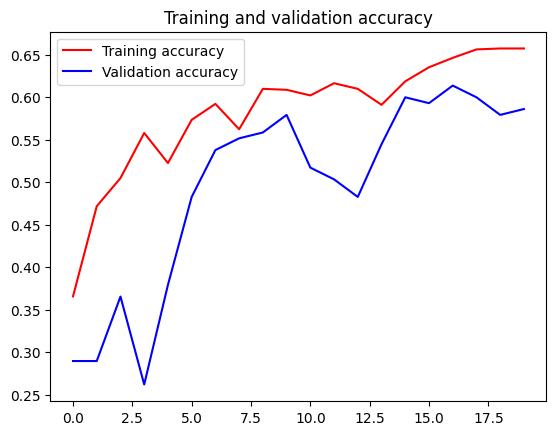

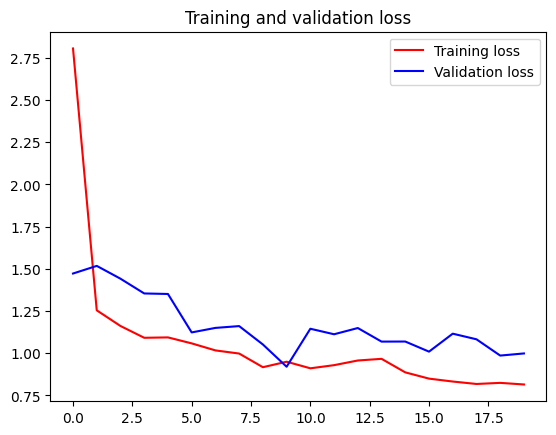

In [11]:
import matplotlib.pyplot as plt
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)